### Imports

In [1]:
import os
import sys
import torch
import numpy as np
import PIL.Image as Image
import matplotlib.pyplot as plt
import torchvision.models as models

from torch.utils.data import DataLoader, random_split

from dataset import GolfHoleSegmentationDataset

### Load Dataset & example

In [2]:
images_dir = "golf_holes"
masks_dir = "golf_hole_masks"

dataset = GolfHoleSegmentationDataset(
    [os.path.join(images_dir, img) for img in os.listdir(images_dir) if img.lower().endswith(".png")],
    [os.path.join(masks_dir, mask) for mask in os.listdir(masks_dir) if mask.lower().endswith(".png")],
    train=True,
)

In [3]:
# --- Split dataset (fixed: random_split expects integer lengths) ---
train_len = int(0.8 * len(dataset))
eval_len  = len(dataset) - train_len

# Reproducible split
g = torch.Generator().manual_seed(42)
train_set, eval_set = random_split(dataset, [train_len, eval_len], generator=g)

train_loader = DataLoader(
    train_set,
    batch_size=4,
    shuffle=True,
    num_workers=2,
    pin_memory=torch.cuda.is_available(),
)
eval_loader = DataLoader(
    eval_set,
    batch_size=4,
    shuffle=False,
    num_workers=2,
    pin_memory=torch.cuda.is_available(),
)

print(f"Train set size: {len(train_set)}")
print(f"Eval  set size: {len(eval_set)}")

Train set size: 128
Eval  set size: 32


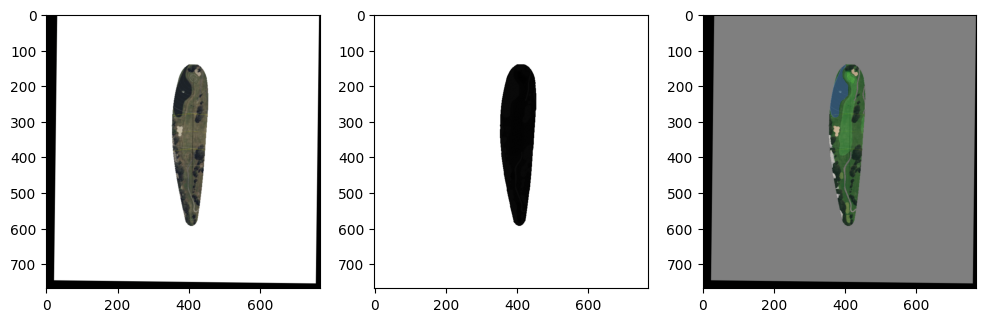

In [5]:
# use the SAME mean/std you used in your transforms
MEAN = np.array([0.485, 0.456, 0.406], dtype=np.float32)
STD  = np.array([0.229, 0.224, 0.225], dtype=np.float32)

def to_vis_uint8(img_chw):
    """img_chw: torch tensor [3,H,W], normalized"""
    x = img_chw.detach().cpu().float().permute(1,2,0).numpy()  # HWC
    x = (x * STD + MEAN)              # back to 0..1
    x = np.clip(x, 0, 1)
    return (x * 255).astype(np.uint8)

index = 50
image, mask = dataset[index]
image = to_vis_uint8(image)
mask  = mask.detach().cpu().numpy()

blended = dataset.blend(image, mask)

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(image)
plt.subplot(1, 3, 2)
plt.imshow(mask, cmap='gray')
plt.subplot(1, 3, 3)
plt.imshow(blended)

plt.show()

### Model

In [ ]:
import torch
import torch.nn.functional as F
from tqdm.auto import tqdm

# --- Model / loss / optimizer ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

num_classes = len(dataset.colors) - 1  # by your earlier choice
model = models.segmentation.fcn_resnet50(num_classes=num_classes)
model = model.to(device)

criterion = torch.nn.CrossEntropyLoss(ignore_index=dataset.IGNORE_INDEX)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.5, patience=2)

def _forward_logits(model, images):
    out = model(images)
    # torchvision segmentation models return dict: {'out': ..., 'aux': ...?}
    if isinstance(out, dict):
        logits = out.get("out", None)
        aux = out.get("aux", None)
        return logits, aux
    return out, None

@torch.no_grad()
def evaluate(model, loader):
    model.eval()
    total_loss = 0.0
    n_batches = 0

    # mIoU accumulators
    inter = torch.zeros(num_classes, device=device, dtype=torch.float64)
    union = torch.zeros(num_classes, device=device, dtype=torch.float64)

    for images, masks in loader:
        images = images.to(device, non_blocking=True)
        masks  = masks.to(device, non_blocking=True).long()

        logits, aux = _forward_logits(model, images)
        loss = criterion(logits, masks)
        total_loss += loss.item()
        n_batches += 1

        preds = logits.argmax(dim=1)

        valid = masks != dataset.IGNORE_INDEX
        for cls in range(num_classes):
            pred_c = (preds == cls) & valid
            mask_c = (masks == cls) & valid
            inter[cls] += (pred_c & mask_c).sum().item()
            union[cls] += (pred_c | mask_c).sum().item()

    iou = inter / torch.clamp(union, min=1.0)
    miou = iou.mean().item()
    return total_loss / max(n_batches, 1), miou, iou.detach().cpu().numpy()

def train_one_epoch(model, loader):
    model.train()
    running = 0.0
    n_batches = 0

    for images, masks in tqdm(loader, desc="train", leave=False):
        images = images.to(device, non_blocking=True)
        masks  = masks.to(device, non_blocking=True).long()

        optimizer.zero_grad(set_to_none=True)
        logits, aux = _forward_logits(model, images)

        loss = criterion(logits, masks)
        # If aux head exists, include a smaller aux loss (common torchvision practice)
        if aux is not None:
            loss = loss + 0.4 * criterion(aux, masks)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        running += loss.item()
        n_batches += 1

    return running / max(n_batches, 1)

# --- Training loop ---
best_eval_loss = float("inf")
best_state = None

epochs = 5
for epoch in range(1, epochs + 1):
    train_loss = train_one_epoch(model, train_loader)
    eval_loss, eval_miou, per_class_iou = evaluate(model, eval_loader)

    scheduler.step(eval_loss)

    lr = optimizer.param_groups[0]["lr"]
    print(f"Epoch {epoch:02d}/{epochs} | lr={lr:.2e} | train_loss={train_loss:.4f} | eval_loss={eval_loss:.4f} | mIoU={eval_miou:.4f}")

    if eval_loss < best_eval_loss:
        best_eval_loss = eval_loss
        best_state = {k: v.detach().cpu() for k, v in model.state_dict().items()}
        torch.save(best_state, "best_fcn_resnet50.pth")
        print("  -> saved best_fcn_resnet50.pth")

# Save final weights too
torch.save(model.state_dict(), "last_fcn_resnet50.pth")
print("Saved last_fcn_resnet50.pth")


c:\Users\nicow\miniconda3\envs\Robot-V2\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to C:\Users\nicow/.cache\torch\hub\checkpoints\resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:08<00:00, 11.6MB/s]
train:  16%|█▌        | 5/32 [09:23<51:25, 114.27s/it]

In [ ]:
# --- Quick qualitative check on a few eval samples ---
import random
model.eval()

def decode_mask(mask_np):
    # dataset.blend expects uint8 mask with class ids; keep as is
    return mask_np.astype(np.uint8)

@torch.no_grad()
def show_predictions(n=3):
    for _ in range(n):
        idx = random.randrange(len(eval_set))
        image_t, mask_t = eval_set[idx]
        image = to_vis_uint8(image_t)
        mask  = mask_t.cpu().numpy().astype(np.uint8)

        logits, _ = _forward_logits(model, image_t.unsqueeze(0).to(device))
        pred = logits.argmax(1).squeeze(0).cpu().numpy().astype(np.uint8)

        plt.figure(figsize=(12,4))
        plt.subplot(1,3,1); plt.title("Image"); plt.imshow(image); plt.axis("off")
        plt.subplot(1,3,2); plt.title("GT mask (blended)"); plt.imshow(dataset.blend(image, mask)); plt.axis("off")
        plt.subplot(1,3,3); plt.title("Pred mask (blended)"); plt.imshow(dataset.blend(image, pred)); plt.axis("off")
        plt.show()

show_predictions(3)